# NLP of IMDB Dataset

The project is to make sentiment analysis of IMDB comments by using Natural Language Processing.

### Dataset
The dataset used in this project is Stanford’s Large Movie Review Dataset as the dataset for sentiment analysis. This dataset is divided into two datasets for training and testing purposes, each containing 25,000 movie reviews downloaded from IMDb. In each dataset, the number of comments labeled as “positive” and “negative” is equal.

## **1. Setting Up the Enivronment**

### 1.1. Import libraries, modules, and functions

In [1]:
# Import libraries, modules, and functions
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import imageio
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchtext.legacy import data


SEED = 1
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **2. Loading and Preparing the Data**

In [2]:
# download the dataset
TEXT = torchtext.legacy.data.Field(tokenizer_language = 'basic_english')   
LABEL = torchtext.legacy.data.Field(dtype = torch.float)
train_data, test_data = torchtext.legacy.datasets.IMDB.splits(TEXT, LABEL) # load IMDB dataset from torchtext.datasets

TEXT.build_vocab(train_data, vectors='glove.6B.50d')
LABEL.build_vocab(train_data)

In [3]:
# print(len(TEXT.vocab))
# print(TEXT.vocab.itos[:12])
# print(TEXT.vocab.stoi['and'])
# print(LABEL.vocab.stoi)

## **3. Computing Word Embeddings**

In [4]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(50):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
[523.5823607444763, 521.1297750473022, 518.6946487426758, 516.2757856845856, 513.8724377155304, 511.4837317466736, 509.106360912323, 506.73851585388184, 504.3805685043335, 502.0331687927246, 499.69424629211426, 497.3644835948944, 495.041216135025, 492.7240858078003, 490.4115951061249, 488.102920293808, 485.7986271381378, 483.49681639671326, 481.1953113079071, 478.89517164230347, 476.5955972671509, 474.29796600341797, 472.00185346603394, 469.703405380249, 467.4039628505707, 465.10329151153564, 462.80123233795166, 460.49805092811584, 458.190958738327, 455.881632566452, 453.56950998306274, 451.25411105155945, 448.93508291244507, 446.6155903339386, 444.2917981147766, 441.9633297920227, 439.6311695575714, 437.29288148880005, 434.9480314254761, 432.5946320295334, 430.2343018054962, 427.86715602874756, 425.49316358566284, 423.1146651506424, 420.7300976514816, 418.34052646160126, 415.9437708854

In [5]:
# TSNE visualization of embeddings

embs = torch.stack([model.embeddings.weight[word_to_ix[word]] for word in vocab]).detach().numpy()
labels = [word for word in vocab]

embs_2d = TSNE(n_components=2).fit_transform(embs)

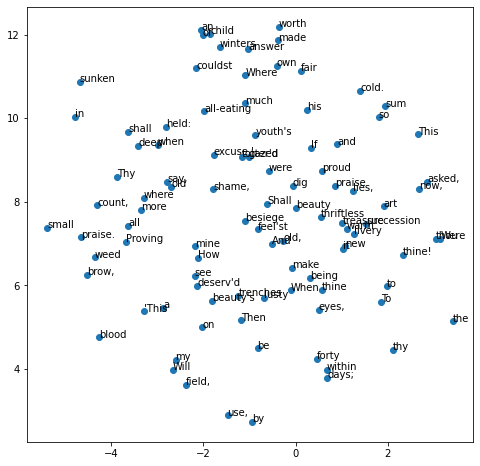

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(embs_2d[:,0], embs_2d[:,1])

for i, txt in enumerate(labels):
    ax.annotate(txt, (embs_2d[i,0], embs_2d[i,1]))

## **4. Sentiment Classification on the IMDB dataset**

In [8]:
TEXT = torchtext.legacy.data.Field(tokenizer_language = 'basic_english')
LABEL = torchtext.legacy.data.LabelField(dtype = torch.float)

In [9]:
train_data, test_data = torchtext.legacy.datasets.IMDB.splits(TEXT, LABEL)

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [11]:
print(vars(train_data.examples[0]))

{'text': ['For', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', 'memorable', 'quotes', 'listed', 'for', 'this', 'gem.', 'Imagine', 'a', 'movie', 'where', 'Joe', 'Piscopo', 'is', 'actually', 'funny!', 'Maureen', 'Stapleton', 'is', 'a', 'scene', 'stealer.', 'The', 'Moroni', 'character', 'is', 'an', 'absolute', 'scream.', 'Watch', 'for', 'Alan', '"The', 'Skipper"', 'Hale', 'jr.', 'as', 'a', 'police', 'Sgt.'], 'label': 'pos'}


In [12]:
print(vars(train_data.examples[2]))

{'text': ['A', 'solid,', 'if', 'unremarkable', 'film.', 'Matthau,', 'as', 'Einstein,', 'was', 'wonderful.', 'My', 'favorite', 'part,', 'and', 'the', 'only', 'thing', 'that', 'would', 'make', 'me', 'go', 'out', 'of', 'my', 'way', 'to', 'see', 'this', 'again,', 'was', 'the', 'wonderful', 'scene', 'with', 'the', 'physicists', 'playing', 'badmitton,', 'I', 'loved', 'the', 'sweaters', 'and', 'the', 'conversation', 'while', 'they', 'waited', 'for', 'Robbins', 'to', 'retrieve', 'the', 'birdie.'], 'label': 'pos'}


In [13]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [15]:
TEXT.build_vocab(train_data, vectors='glove.6B.50d')
LABEL.build_vocab(train_data)

In [16]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 224428
Unique tokens in LABEL vocabulary: 2


In [17]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 200714), ('a', 108362), ('and', 106643), ('of', 100046), ('to', 93152), ('is', 72104), ('in', 59701), ('I', 46420), ('that', 45281), ('this', 40144), ('it', 38172), ('/><br', 35632), ('was', 32551), ('as', 29641), ('with', 29266), ('for', 28713), ('but', 23712), ('The', 23645), ('on', 21540), ('movie', 21405)]


In [18]:
def get_batch_sentence_embeddings(batch):
    sentence_embeddings = []
    for text in batch.text.transpose(1,0):
        filtered_text = text[(text!=0)&(text!=1)] # removes <unk> and <pad> tokens
        sentence_emb = torch.mean(TEXT.vocab.vectors[filtered_text],axis=0)
        sentence_embeddings.append(sentence_emb)
    
    return torch.stack(sentence_embeddings)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim,1)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [19]:
# dataloader
BATCH_SIZE = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)


# model + loss + optimizer
model = LogisticRegression(input_dim=50)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [20]:
# Number of training epochs 
epochs = 30

# Train model/iterate over epochs
losses = []
for epoch in range(int(epochs)):
    for i,batch in tqdm(enumerate(train_iterator)):
        
        sentence_embeddings = get_batch_sentence_embeddings(batch)
        optimizer.zero_grad()
        outputs = model(sentence_embeddings)
        loss = criterion(outputs.reshape(-1), batch.label)
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())

print(losses)

175it [00:03, 57.97it/s]
175it [00:02, 59.31it/s]
175it [00:02, 58.89it/s]
175it [00:02, 60.54it/s]
175it [00:02, 61.15it/s]
175it [00:02, 60.99it/s]
175it [00:02, 61.36it/s]
175it [00:02, 61.30it/s]
175it [00:02, 60.90it/s]
175it [00:02, 61.71it/s]
175it [00:02, 58.80it/s]
175it [00:03, 58.32it/s]
175it [00:02, 59.81it/s]
175it [00:02, 58.94it/s]
175it [00:02, 58.92it/s]
175it [00:02, 58.93it/s]
175it [00:03, 57.07it/s]
175it [00:02, 59.21it/s]
175it [00:02, 59.12it/s]
175it [00:03, 57.96it/s]
175it [00:02, 59.93it/s]
175it [00:03, 57.80it/s]
175it [00:03, 57.35it/s]
175it [00:02, 61.17it/s]
175it [00:03, 56.94it/s]
175it [00:02, 58.69it/s]
175it [00:02, 58.39it/s]
175it [00:02, 59.11it/s]
175it [00:02, 59.99it/s]
175it [00:03, 56.50it/s]

[0.6899785399436951, 0.688189685344696, 0.6892403364181519, 0.6863414645195007, 0.6894131302833557, 0.6847732663154602, 0.6876772046089172, 0.685048520565033, 0.6785286068916321, 0.678961992263794, 0.6807585954666138, 0.6814345717430115, 0.6826913356781006, 0.6858171820640564, 0.6822817921638489, 0.6743022799491882, 0.6687901020050049, 0.6722944378852844, 0.6751839518547058, 0.6774967908859253, 0.6761327981948853, 0.6781578063964844, 0.6767597198486328, 0.6788173913955688, 0.6681549549102783, 0.6700043678283691, 0.6728254556655884, 0.6669890880584717, 0.6662335395812988, 0.6742249131202698]


In [21]:
def compute_metrics(iterator,model):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in iterator:
        sentence_embeddings = get_batch_sentence_embeddings(batch)
        with torch.no_grad():
            all_preds.extend(list(model(sentence_embeddings).detach().numpy()))
        all_labels.extend(list(batch.label.detach().numpy()))
    
    return {'auc': roc_auc_score(all_labels,all_preds)}

In [22]:
compute_metrics(test_iterator,model)

{'auc': 0.7291410848000001}